In [1]:
import math
from os import listdir
from itertools import product
from collections import Counter
import dill as pickle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy.stats import ks_2samp, entropy
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
sns.set(rc={"figure.dpi": 150})


from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, rdMolDescriptors, MolFromSmiles, MolToSmiles, Draw, MolFromMolFile
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

from rdkit.Chem import ChemicalFeatures
from rdkit import Geometry
from rdkit.Chem.rdmolfiles import MolFromPDBBlock, MolFromPDBFile
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.RDPaths import RDDataDir
import os.path

fdefFile = os.path.join(RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefFile)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # removes annoying RDKit warnings

import py3Dmol
import mols2grid

from rdkit.Chem.SaltRemover import SaltRemover
remover = SaltRemover()

import frag_funcs
import importlib
importlib.reload(frag_funcs)

from ipywidgets import interact

pairs = ['Donor-Aromatic',
        'Aromatic-Acceptor',
        'Aromatic-Aromatic',
        'Donor-Donor',
        'Donor-Acceptor',
        'Acceptor-Acceptor']

import KDEpy 


# MPro EF curves

In [4]:
def enrichment(score_df, n=10, score='score', index='hit', log=False, ascending=True):
    df = score_df[score_df[score].notna()].copy() # ignores NaNs
    df.loc[:, score] = df[score].astype(float)
    orig_prop = len(df.loc[df[index]])/len(df)
    if log:
        print('orig proportion of {}: {:.3f}%'.format(index, orig_prop*100))
    
    # sorted_df = df.sort_values(by=score, ascending=ascending).iloc[:n]
    # sorted_df = df.nsmallest(n=n, columns=score)
    sorted_df = df.nlargest(n=n, columns=score)

    new_prop = len(sorted_df[sorted_df[index]])/len(sorted_df)
    if log:
        print('N = {}, n_hits = {}, new proportion of {}: {:.3f}%'.format(n, len(sorted_df[sorted_df[index]]),index, new_prop*100))
    EF = new_prop/orig_prop
    return EF

In [5]:
# load ligands 
interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

hits = pickle.load(open(data_dir+'/hits_new.pickle', 'rb'))   
threshold = 5 # IC50 threshold for activity 

# hits = pickle.load(open('hits_may.list', 'rb')) 
#   
hitpcore_df = frag_funcs.return_pcore_dataframe(hits, interesting_pcores, hit=True, threshold=threshold)

smiles_list = [None]*len(set(hitpcore_df['mol_id']))  
activity_list = [None]*len(set(hitpcore_df['mol_id']))
IC50_list = [None]*len(set(hitpcore_df['mol_id']))

for i in tqdm(set(hitpcore_df['mol_id'])):
    smiles_list[i] = hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['smiles']
    activity_list[i] = hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['active']
    IC50_list[i] = hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['IC50']

xray_hit_pairs = pickle.load(open(data_dir+'/hit_pairs.pickle', 'rb'))

xray_df = pd.DataFrame(columns=['smiles', 'hit']+pairs)
xray_df['smiles'] = smiles_list
xray_df['hit'] = activity_list

xray_prop = len(xray_df[xray_df['hit']])/len(xray_df)
print('base rate = {:.1f}%'.format(xray_prop*100))
assert len(hits) == len(xray_hit_pairs)

100%|██████████| 213/213 [00:00<00:00, 444.25it/s]

base rate = 11.7%


## Generate pharmacophore distribution for moonshot molecules

In [7]:
hit_mols = [None]*len(hits)
for i,hit in tqdm(enumerate(hits), total=len(hits)):
    try:
        mol = MolFromSmiles(MolToSmiles(hit[0]))

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)

        mol = Chem.RemoveHs(mol)

        #calculate properties from surviving conformers
        conf = mol.GetConformer()

        mol_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            mol_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]
                                ])
        mol_data.append(hit[-1])
        hit_mols[i] = mol_data
    except Exception as ex:
        print(ex)
        print(str(i)+' failed')
        continue
    
hitpcore_df = frag_funcs.return_pcore_dataframe(hit_mols, interesting_pcores, hit=True, threshold=threshold)

fresh_hit_pairs = [None]*len(set(hitpcore_df['mol_id']))
for j,i in tqdm(enumerate(set(hitpcore_df['mol_id'])), total=len(fresh_hit_pairs)):
    hit_pair_individual = {}
    
    for pcore_pair in product(interesting_pcores,repeat=2):
        core_a,core_b = pcore_pair
        combo = core_a+'-'+core_b
        hit_pair_individual[combo], _ = frag_funcs.get_pair_distances(hitpcore_df[hitpcore_df['mol_id']==i], core_a, core_b, frag=False, active=None)
    fresh_hit_pairs[j] = hit_pair_individual

100%|██████████| 213/213 [00:24<00:00,  8.81it/s]


### All moonshot molecules

In [6]:
df = pd.read_csv('../data/activity_data.csv')
df = df[(df['acrylamide']==False) & (df['chloroacetamide']==False)]
df.reset_index(inplace=True)

all_mols = [None]*len(df)
for i,row in tqdm(df.iterrows(), total=len(df)):
    try:
        mol = MolFromSmiles(row['SMILES'])

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)

        mol = Chem.RemoveHs(mol)

        #calculate properties from surviving conformers
        conf = mol.GetConformer()

        mol_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            mol_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]
                                ])
        # NaNs
        mol_data.append(row['f_avg_IC50'])
        all_mols[i] = mol_data
    except Exception as ex:
        print(ex)
        print(str(i)+' failed')
        continue
all_mols = [mol for mol in all_mols if mol is not None]

threshold = 5 # IC50 threshold for activity 
hitpcore_df = frag_funcs.return_pcore_dataframe(all_mols, interesting_pcores, hit=True, threshold=threshold)

fresh_hit_pairs = [None]*len(set(hitpcore_df['mol_id']))
for j,i in tqdm(enumerate(set(hitpcore_df['mol_id'])), total=len(fresh_hit_pairs)):
    hit_pair_individual = {}
    
    for pcore_pair in product(interesting_pcores,repeat=2):
        core_a,core_b = pcore_pair
        combo = core_a+'-'+core_b
        hit_pair_individual[combo], _ = frag_funcs.get_pair_distances(hitpcore_df[hitpcore_df['mol_id']==i], core_a, core_b, frag=False, active=None)
    fresh_hit_pairs[j] = hit_pair_individual

smiles_list = []
activity_list = []
for i in tqdm(set(hitpcore_df['mol_id'])):
    smiles_list.append(hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['smiles'])
    activity_list.append(hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['active'])
    
fresh_df = pd.DataFrame(columns=['smiles', 'hit']+pairs)
fresh_df['smiles'] = smiles_list
fresh_df['hit'] = activity_list

fresh_prop = len(fresh_df[fresh_df['hit']])/len(fresh_df)
print('base rate = {:.1f}%'.format(fresh_prop*100))

100%|██████████| 1360/1360 [00:01<00:00, 803.46it/s]

base rate = 31.1%


Xray: Prop of NaNs for Donor-Aromatic = 6.1%
Fresh: Prop of NaNs for Donor-Aromatic = 7.9%
Xray: Prop of NaNs for Donor-Acceptor = 6.1%
Fresh: Prop of NaNs for Donor-Acceptor = 7.7%
Xray: Prop of NaNs for Aromatic-Aromatic = 0.0%
Fresh: Prop of NaNs for Aromatic-Aromatic = 0.4%
Xray: Prop of NaNs for Donor-Donor = 6.1%
Fresh: Prop of NaNs for Donor-Donor = 7.6%
Xray: Prop of NaNs for Aromatic-Acceptor = 0.0%
Fresh: Prop of NaNs for Aromatic-Acceptor = 0.6%
Xray: Prop of NaNs for Acceptor-Acceptor = 0.0%
Fresh: Prop of NaNs for Acceptor-Acceptor = 0.3%


/rds-d2/user/wjm41/hpc-work/conda/envs/felix_md/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice
/rds-d2/user/wjm41/hpc-work/conda/envs/felix_md/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice


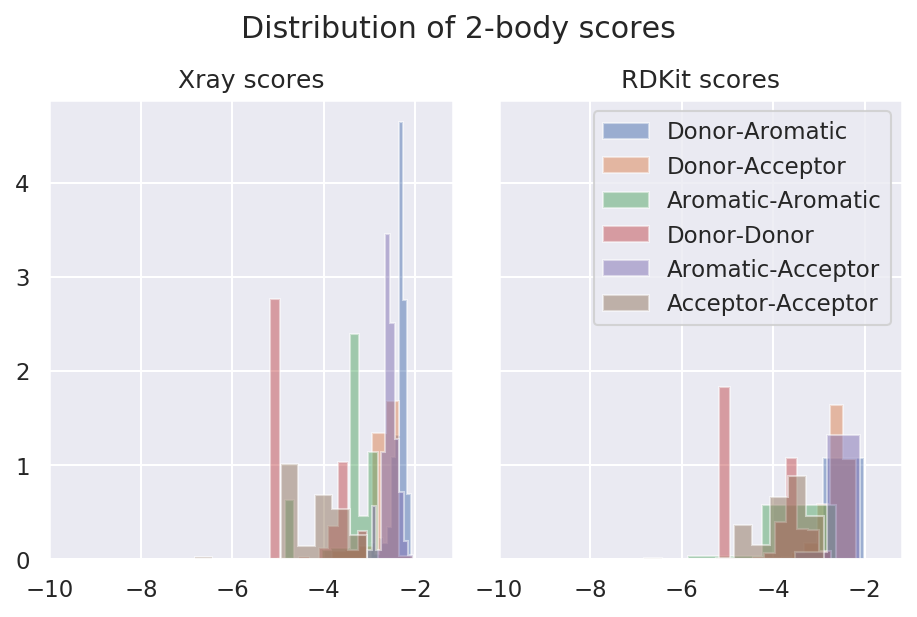

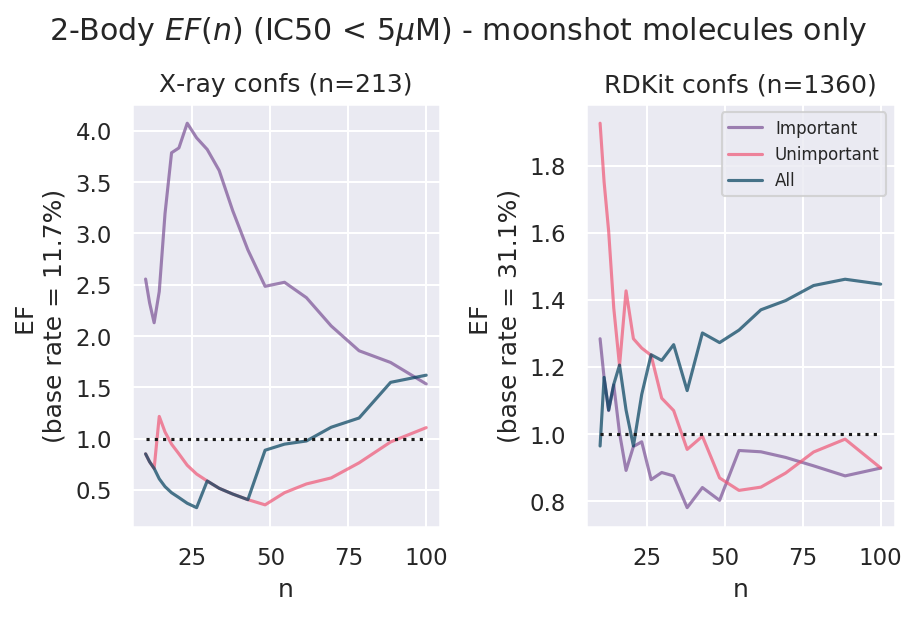

In [7]:
# pd.options.mode.chained_assignment = 'raise'
def score_dist(kde, dist):
    if len(dist): # non-zero length

        # log-prob (larger = higher prob)
        # score using scipy spline!
        score = kde(dist.reshape(-1, 1))

        # score = kde.score_samples(dist.reshape(-1,1))
        score = np.mean(score)
        
        # mask = score<-6

        # score = np.where(mask, np.nan, score)
        # score = np.nanmean(score)

        # score = np.exp(np.where(mask, np.nan, score))
        # df.at[i, combo] = np.nansum(score)
        return score
    else:
        return np.nan

# weigh & score pharmacophores

important = ['Donor-Aromatic',
             'Donor-Acceptor',
            'Aromatic-Aromatic']
unimportant = ['Donor-Donor',
               'Aromatic-Acceptor',
               'Acceptor-Acceptor']

# kde_dict_opt = pickle.load(open('pickles/kde_dict_opt_mpro.pickle', 'rb'))
kde_dict_opt = new_kdes

pairs = important+unimportant

num_weights = np.empty((len(pairs)))

for j,combo in enumerate(pairs):
    core_a,core_b = combo.split('-')
    num_weights[j] = len(frag_pair_distance_dict[combo])
    kde = kde_dict_opt[combo]

    # rand_kdes = []
    # for n in range(n_rand):
    #     kdepy_model = FFTKDE(kernel='gaussian', bw='ISJ').fit(
    #     rand_pair_dicts[n][combo])
    #     kdepy_bw = kdepy_model.bw

    #     kde_new = KernelDensity(
    #         kernel='gaussian', bandwidth=kdepy_bw, rtol=1e-4).fit(rand_pair_dicts[n][combo].reshape(-1, 1))
    #     rand_kdes.append(kde_new)

    for i in range(len(xray_hit_pairs)):
        dist = xray_hit_pairs[i][combo][0]
        
        xray_df.at[i, combo] = score_dist(kde, dist)

        # xray_df.at[i, combo] = n_rand*score_dist(kde, dist)
        # for n in range(n_rand):
        #     xray_df.at[i, combo] -= score_dist(rand_kdes[n], dist)

            
    for i in range(len(fresh_hit_pairs)):
        fresh_dist = fresh_hit_pairs[i][combo][0]
        
        fresh_df.at[i, combo] = score_dist(kde, fresh_dist)

        # fresh_df.at[i, combo] = n_rand*score_dist(kde, fresh_dist)
        # for n in range(n_rand):
        #     fresh_df.at[i, combo] -= score_dist(rand_kdes[n], fresh_dist)

    print('Xray: Prop of NaNs for {} = {:.1f}%'.format(combo, 100*len(xray_df[xray_df[combo].isnull()])/len(xray_df)))
    print('Fresh: Prop of NaNs for {} = {:.1f}%'.format(
        combo, 100*len(fresh_df[fresh_df[combo].isnull()])/len(fresh_df)))

# CALCULATE EFs
# num_weights = np.array([0,0,1,0,0,0])

hit_dfs = [xray_df, fresh_df]
for hit_df in hit_dfs:
    hit_df[pairs] = hit_df[pairs].astype(float)

    hit_df['imp_score'] = np.nanmean(hit_df[important].to_numpy(), axis=1)
    hit_df['nonimp_score'] = np.nanmean(hit_df[unimportant].to_numpy(), axis=1)
    hit_df['hit'] = hit_df['hit'].astype('Int64').astype(bool)

    x = hit_df[pairs].to_numpy()
    hit_df['both_score'] = np.nanmean(x, axis=1)
    # hit_df['weighed_score'] = np.where(np.isnan(x), 0, x).dot(num_weights)/np.where(np.isnan(x), 0, 1).dot(num_weights)

# PLOT HISTOGRAMS
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                        dpi=150, constrained_layout=True)
for pair in pairs:
    axs[0].hist(xray_df[xray_df[pair].notnull()][pair].astype(float).values, density=True,
                alpha=0.5, histtype='stepfilled', label=pair)
    axs[1].hist(fresh_df[fresh_df[pair].notnull()][pair].astype(float).values, density=True,
             alpha=0.5, histtype='stepfilled', label=pair)
             
axs[0].set_title('Xray scores')
axs[1].set_title('RDKit scores')
axs[0].set_xlim(left=-10)
axs[1].set_xlim(left=-10)
axs[1].legend()
fig.suptitle('Distribution of 2-body scores')
plt.show()

n_list = np.logspace(start=1, stop=2, num=20) # only check from 10 to 100

xray_EF = [enrichment(xray_df, n=int(n), score='both_score') for n in n_list]
xray_EF_imp = [enrichment(xray_df, n=int(n), score='imp_score') for n in n_list]
xray_EF_nonimp = [enrichment(xray_df, n=int(n), score='nonimp_score') for n in n_list]
# xray_EF_weighed = [enrichment(xray_df, n=int(n),  score='weighed_score') for n in n_list]

fresh_EF = [enrichment(fresh_df, n=int(n), score='both_score') for n in n_list]
fresh_EF_imp = [enrichment(fresh_df, n=int(n), score='imp_score') for n in n_list]
fresh_EF_nonimp = [enrichment(fresh_df, n=int(n), score='nonimp_score') for n in n_list]
# fresh_EF_weighed = [enrichment(fresh_df, n=int(n),  score='weighed_score') for n in n_list]

xray_prop = len(xray_df[xray_df['hit']])/len(xray_df)
fresh_prop = len(fresh_df[fresh_df['hit']])/len(fresh_df)

# PLOTTING

# fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, dpi=200, constrained_layout=True)
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, dpi=150, constrained_layout=True)
axs[0].plot(n_list, xray_EF_imp, '-', label='Important',
            color='#7a5195', alpha=0.7)
axs[0].plot(n_list, xray_EF_nonimp, '-', label='Unimportant', color='#ef5675', alpha=0.7) 
axs[0].plot(n_list, xray_EF, '-', label='All', color='#003f5c', alpha=0.7)
# axs[0].plot(n_list, xray_EF_weighed, '-', label='Weighed', color='#ffa600', alpha=0.7) 

axs[1].plot(n_list, fresh_EF_imp, '-', label='Important', color='#7a5195', alpha=0.7)
axs[1].plot(n_list, fresh_EF_nonimp, '-', label='Unimportant', color='#ef5675', alpha=0.7) 
axs[1].plot(n_list, fresh_EF, '-', label='All', color='#003f5c', alpha=0.7)
# axs[1].plot(n_list, fresh_EF_weighed, '-', label='Weighed', color='#ffa600', alpha=0.7) 

fig.suptitle(r'2-Body $EF(n)$ (IC50 < {}$\mu$M) - moonshot molecules only'.format(threshold))
axs[0].set_title('X-ray confs (n={})'.format(len(xray_df)))
axs[1].set_title('RDKit confs (n={})'.format(len(fresh_df)))
# plt.xscale('log')
plt.legend(prop={'size': 8})

for ax in axs:
    ax.plot(n_list, np.ones_like(n_list), 'k:')

    # extraticks = [1]
    # ax.set_yticks(list(plt.yticks()[0]) + extraticks)
    # ax.set_ylim(bottom=0)
    ax.set_xlabel('n')
axs[0].set_ylabel('EF \n(base rate = {:.1f}%)'.format(xray_prop*100))
axs[1].set_ylabel('EF \n(base rate = {:.1f}%)'.format(fresh_prop*100))
plt.show()


### Comparison vs ZINC

In [8]:
### Generate random ZINC conformer 26/02/2021
import random 

n_zinc = 5000

# zinc_smi = pd.read_csv(zinc_dir+'/zinc_subset.smi', delim_whitespace=True)['smiles'].values
zinc_smi = pd.read_csv('/rds-d2/user/wjm41/hpc-work/datasets/ZINC/zinc_250k.csv')['smiles'].values

rand_smi = random.sample(list(zinc_smi), k=n_zinc)

zinc_mols = [None]*len(rand_smi)
for i,smi in tqdm(enumerate(rand_smi), total=len(rand_smi)):
    try:
        mol = MolFromSmiles(smi)

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)

        mol = Chem.RemoveHs(mol)

        #calculate properties from surviving conformers
        conf = mol.GetConformer()

        mol_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            mol_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]
                                ])
        zinc_mols[i] = mol_data
    except:
        print(str(i)+' failed')
        continue
assert len(zinc_mols) == n_zinc
print('Number of sampled molecules :{}'.format(len(zinc_mols)))

zinc_mols = [ i for i in zinc_mols if i]

interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

important = ['Donor-Aromatic',
            'Aromatic-Acceptor',
            'Aromatic-Aromatic']
unimportant = ['Donor-Donor',
               'Donor-Acceptor',
               'Acceptor-Acceptor']

pairs = important+unimportant
zinccore_df = frag_funcs.return_pcore_dataframe(zinc_mols, interesting_pcores, hit=False)

zinc_pairs = [None]*len(set(zinccore_df['mol_id']))
for j,i in tqdm(enumerate(set(zinccore_df['mol_id'])), total=len(zinc_pairs)):
    zinc_pair_individual = {}
    
    for combo in pairs:
        core_a,core_b = combo.split('-')
        zinc_pair_individual[combo], _ = frag_funcs.get_pair_distances(zinccore_df[zinccore_df['mol_id']==i], core_a, core_b, frag=False, active=None)
    zinc_pairs[j] = zinc_pair_individual

zinc_smi = []
zinc_activity = []

for i in tqdm(set(zinccore_df['mol_id'])):
    zinc_smi.append(zinccore_df[zinccore_df['mol_id']==i].iloc[0]['smiles'])
    zinc_activity.append(False)
    
assert len(zinc_smi) == len(zinc_pairs)

 52%|█████▏    | 2587/5000 [02:09<36:31,  1.10it/s]

2581 failed


  0%|          | 9/4999 [00:00<01:01, 81.38it/s]

Number of sampled molecules :5000


100%|██████████| 4999/4999 [00:03<00:00, 1559.11it/s]


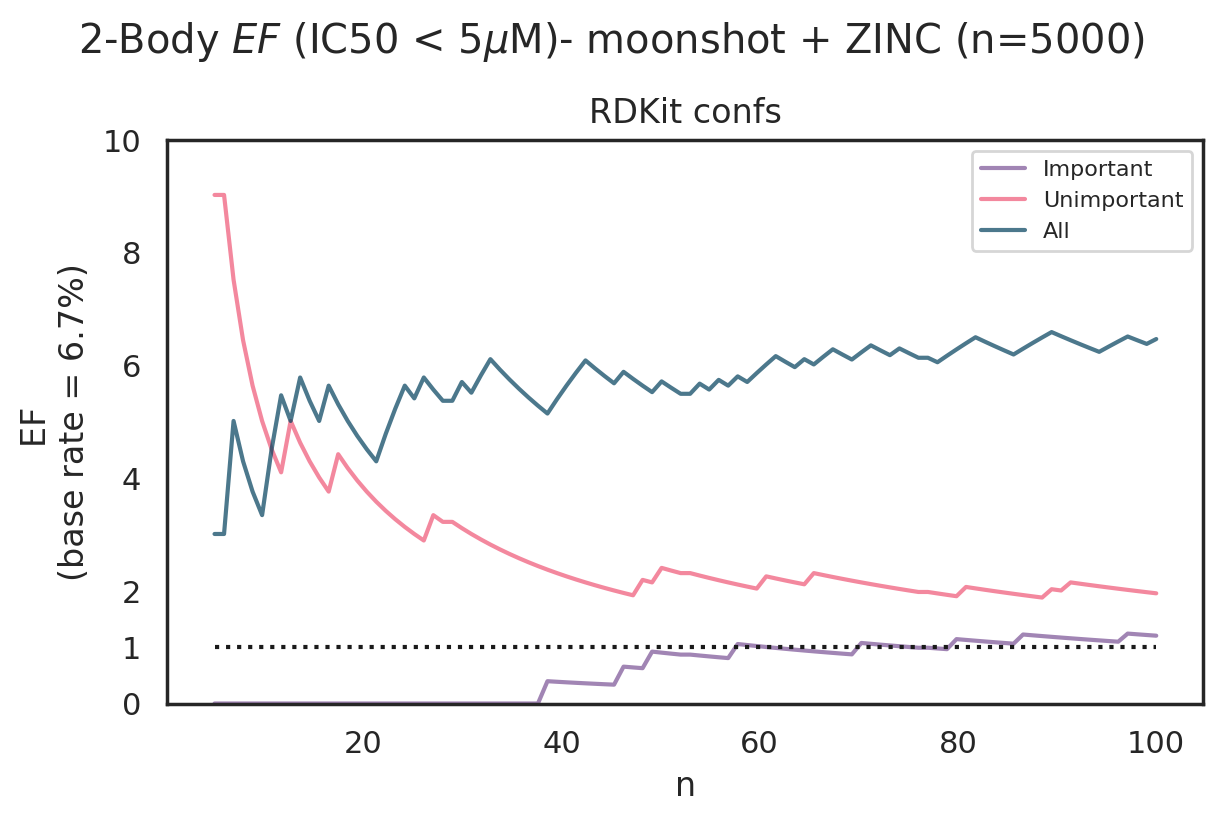

In [68]:
# weigh & score pharmacophores

important = ['Donor-Aromatic',
             'Donor-Acceptor',
            'Aromatic-Aromatic']
unimportant = ['Donor-Donor',
               'Aromatic-Acceptor',
               'Acceptor-Acceptor']

# kde_dict_opt = pickle.load(open('pickles/kde_dict_opt_mpro.pickle', 'rb'))
kde_dict_opt = new_kdes

pairs = important+unimportant

zinc_df = pd.DataFrame(columns=['smiles', 'hit']+pairs)
zinc_df['smiles'] = zinc_smi
zinc_df['hit'] = zinc_activity

num_weights = np.empty((len(pairs)))

for j,combo in enumerate(pairs):
    core_a,core_b = combo.split('-')
    num_weights[j] = len(frag_pair_distance_dict[combo])
    kde = kde_dict_opt[combo]

    # w = p_dict[combo]

    for i in range(len(fresh_hit_pairs)):
        fresh_dist = fresh_hit_pairs[i][combo][0]

        fresh_df.at[i, combo] = score_dist(kde, fresh_dist)#/w

    for i in range(len(zinc_pairs)):
        zinc_dist = zinc_pairs[i][combo][0]

        zinc_df.at[i, combo] = score_dist(kde, zinc_dist)#/w

# CALCULATE EFs
# num_weights = np.array([0,0,1,0,0,0])
# num_weights = d_median

fresh_df['df'] = 'Moonshot'
zinc_df['df'] = 'ZINC'
total_df = pd.concat([fresh_df, zinc_df]).reset_index()

total_df[pairs] = total_df[pairs].astype(float)
x = total_df[important].to_numpy()
x[np.all(np.isnan(x), axis=1)] = -100
total_df['imp_score'] = np.nanmean(x, axis=1)
x = total_df[unimportant].to_numpy()
x[np.all(np.isnan(x), axis=1)] = -100
total_df['nonimp_score'] = np.nanmean(x, axis=1)
# total_df['imp_score'] = np.ma.mean(total_df[important].to_numpy(), axis=1)
# total_df['nonimp_score'] = np.ma.mean(total_df[unimportant].to_numpy(), axis=1)
total_df['hit'] = total_df['hit'].astype('Int64').astype(bool)

x = total_df[pairs].to_numpy()
x[np.all(np.isnan(x), axis=1)] = -100
total_df['both_score'] = np.nanmean(
    x, axis=1)


# total_df['both_score'] = np.nanmin(x, axis=1)
# total_df['both_score'] = np.ma.sum(total_df[pairs].to_numpy(na_value=False), axis=1)
# scores = total_df[pairs].to_numpy().astype(float)
# total_df['weighed_score'] = np.where(np.isnan(x), 0, x).dot(num_weights)/np.where(np.isnan(x), 0, 1).dot(num_weights)
# print(total_df.head())

# fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
#                         dpi=200, constrained_layout=True)
# for pair in pairs:
#     axs[0].hist(fresh_df[fresh_df[pair].notnull()][pair].astype(float).values, density=True,
#                 alpha=0.5, histtype='stepfilled', label=pair)
#     axs[1].hist(zinc_df[zinc_df[pair].notnull()][pair].astype(float).values, density=True,
#                 alpha=0.5, histtype='stepfilled', label=pair)

# plt.legend(loc='upper left')
# axs[0].set_title('Moonshot scores')
# axs[1].set_title('ZINC scores')
# axs[0].set_xlim(left=-10)
# axs[1].set_xlim(left=-10)
# fig.suptitle('Distribution of 2-body scores')
# plt.show()

# sns.displot(total_df[total_df['both_score'].notnull()],
#             x='both_score', hue='df', stat='density')
# plt.xlim(left=-10)
# sns.displot(total_df[total_df['imp_score'].notnull()], x='imp_score', hue='df', stat='density')
# plt.xlim(left=-10)
# sns.displot(total_df[total_df['nonimp_score'].notnull()], x='nonimp_score', hue='df', stat='density')
# plt.xlim(left=-10)
# sns.displot(total_df[total_df['weighed_score'].notnull()], x='weighed_score', hue='df', stat='density')
# plt.xlim(left=-10)

# plt.hist(total_df['both_score'].values, density=True, alpha=0.5, histtype='stepfilled', label='both_score')
# plt.hist(total_df['imp_score'].values, density=True, alpha=0.5, histtype='stepfilled', label='imp_score')
# plt.hist(total_df['nonimp_score'].values, density=True, alpha=0.5, histtype='stepfilled', label='nonimp_score')
# plt.hist(total_df['weighed_score'].values, density=True, alpha=0.5, histtype='stepfilled', label='weighed_score')

# n_list = np.logspace(start=np.log10(5), stop=2, num=20) # only check top 100
n_list = np.linspace(start=5, stop=100, num=100)

fresh_EF = [enrichment(total_df, n=int(n), score='both_score') for n in n_list]
fresh_EF_imp = [enrichment(total_df, n=int(n), score='imp_score') for n in n_list]
fresh_EF_nonimp = [enrichment(total_df, n=int(n), score='nonimp_score') for n in n_list]
# fresh_EF_weighed = [enrichment(total_df, n=int(n),  score='weighed_score') for n in n_list]

orig_prop = len(total_df[total_df['hit']])/len(total_df)

# PLOTTING
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, dpi=200, constrained_layout=True)

ax.plot(n_list, fresh_EF_imp, '-', label='Important', color='#7a5195', alpha=0.7)
ax.plot(n_list, fresh_EF_nonimp, '-', label='Unimportant', color='#ef5675', alpha=0.7) 
ax.plot(n_list, fresh_EF, '-', label='All', color='#003f5c', alpha=0.7)
# ax.plot(n_list, fresh_EF_weighed, '-', label='Weighed', color='#ffa600', alpha=0.7) 

fig.suptitle(r'2-Body $EF$ (IC50 < {}$\mu$M)- moonshot + ZINC (n={})'.format(threshold, n_zinc))
ax.set_title('RDKit confs')
# plt.xscale('log')
plt.legend(prop={'size': 8})


ax.plot(n_list, np.ones_like(n_list), 'k:')

extraticks = [1]
ax.set_yticks(list(plt.yticks()[0]) + extraticks)
ax.set_ylim(bottom=0)
ax.set_xlabel('n')
ax.set_ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
plt.show()


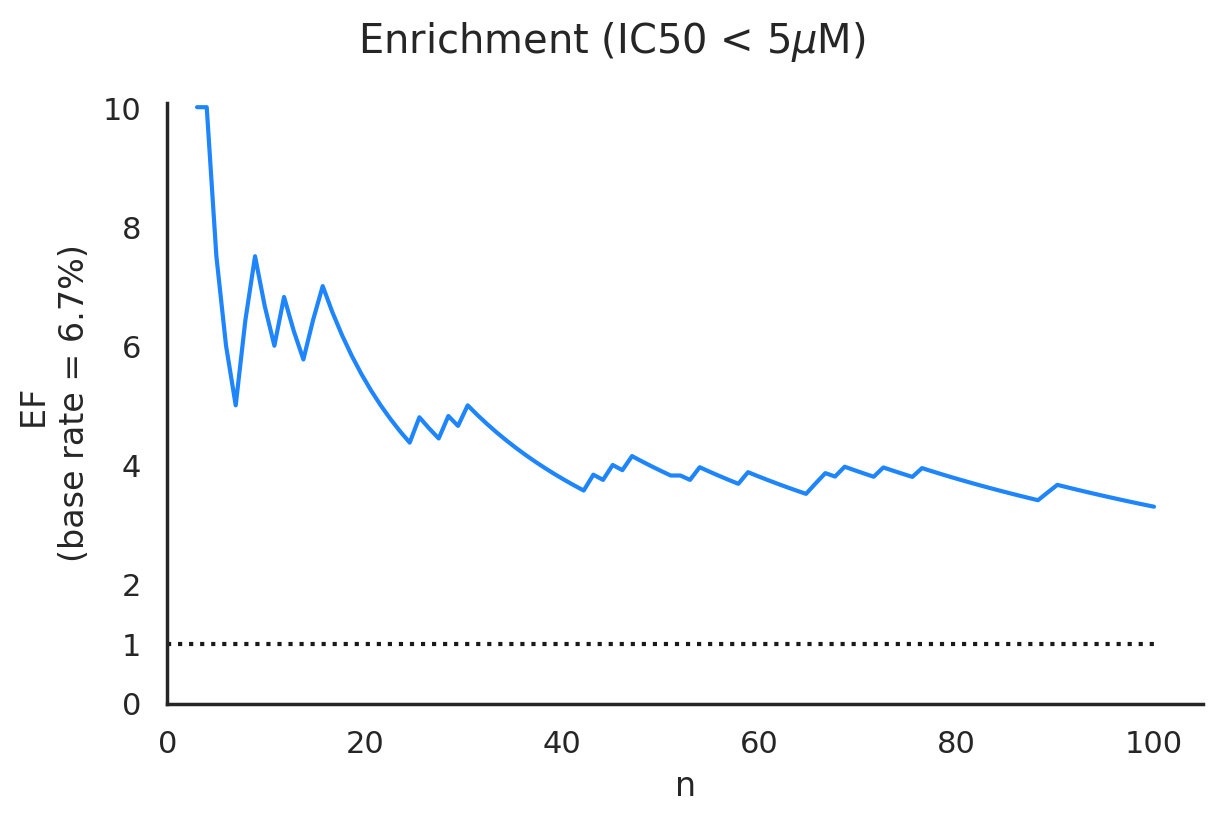

In [54]:
sns.set(font='Free Mono')
sns.set_style('white')
orig_prop = len(total_df[total_df['hit']])/len(total_df)

# PLOTTING
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, dpi=200, constrained_layout=True)
fig.suptitle(r'Enrichment (IC50 < {}$\mu$M)'.format(threshold))
# plt.xscale('log')
# plt.legend(prop={'size': 8})

n_list = np.linspace(start=3, stop=100, num=100)  # only check top 100
fresh_EF = [enrichment(total_df, n=int(n), score='both_score') for n in n_list]
ax.plot(n_list, fresh_EF, '-', color='#1E85FC')
ax.plot([0, 100], [1, 1], 'k:')

extraticks = [1]
ax.set_yticks(list(plt.yticks()[0]) + extraticks)
ax.set_ylim(bottom=0, top=10.1)
ax.set_xlim(left=0)
ax.set_xlabel('n')
ax.set_ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
sns.despine()
plt.show()


In [13]:
n = 1 

num_weights = np.array([1,1,1,0,0,0])
imp_score = np.nanmean(hit_df[important].to_numpy()[n], axis=0)

x = hit_df[pairs].to_numpy()[n].astype(float)
weigh_score = np.where(np.isnan(x), 0, x).dot(num_weights)/np.where(np.isnan(x), 0, 1).dot(num_weights)
print(np.where(np.isnan(x), 0, 1).dot(num_weights))

print(imp_score)
print(weigh_score)

3
-2.4513186599462458
-2.4513186599462458


# Plot CDFs

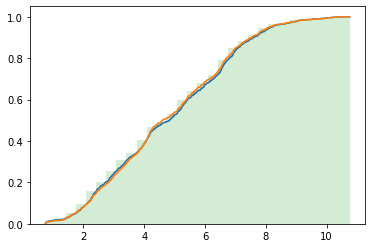

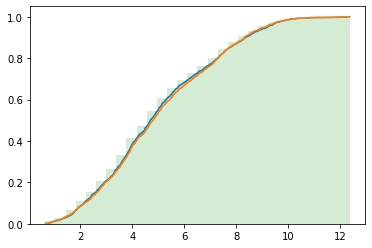

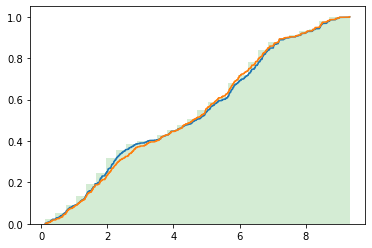

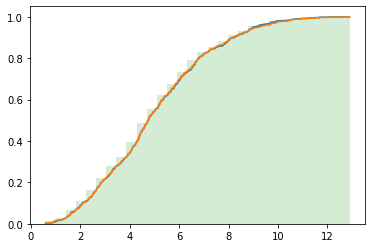

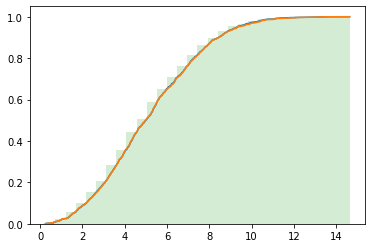

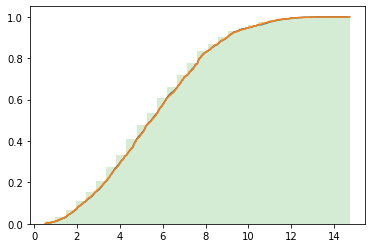

In [ ]:
for combo in pairs:
    X2 = np.sort(frag_pair_distance_dict[combo])
    W = frag_weight_dict[combo][np.argsort(frag_pair_distance_dict[combo])]
    N = len(frag_pair_distance_dict[combo])
    F2 = np.array(range(N))/float(N)

    plt.plot(X2, F2)
    plt.plot(X2, np.cumsum(W)/np.sum(W))
    plt.hist(frag_pair_distance_dict[combo], bins=30, alpha=0.2, density=True, cumulative=True)
    plt.show()

100%|██████████| 6/6 [00:00<00:00, 29.53it/s]


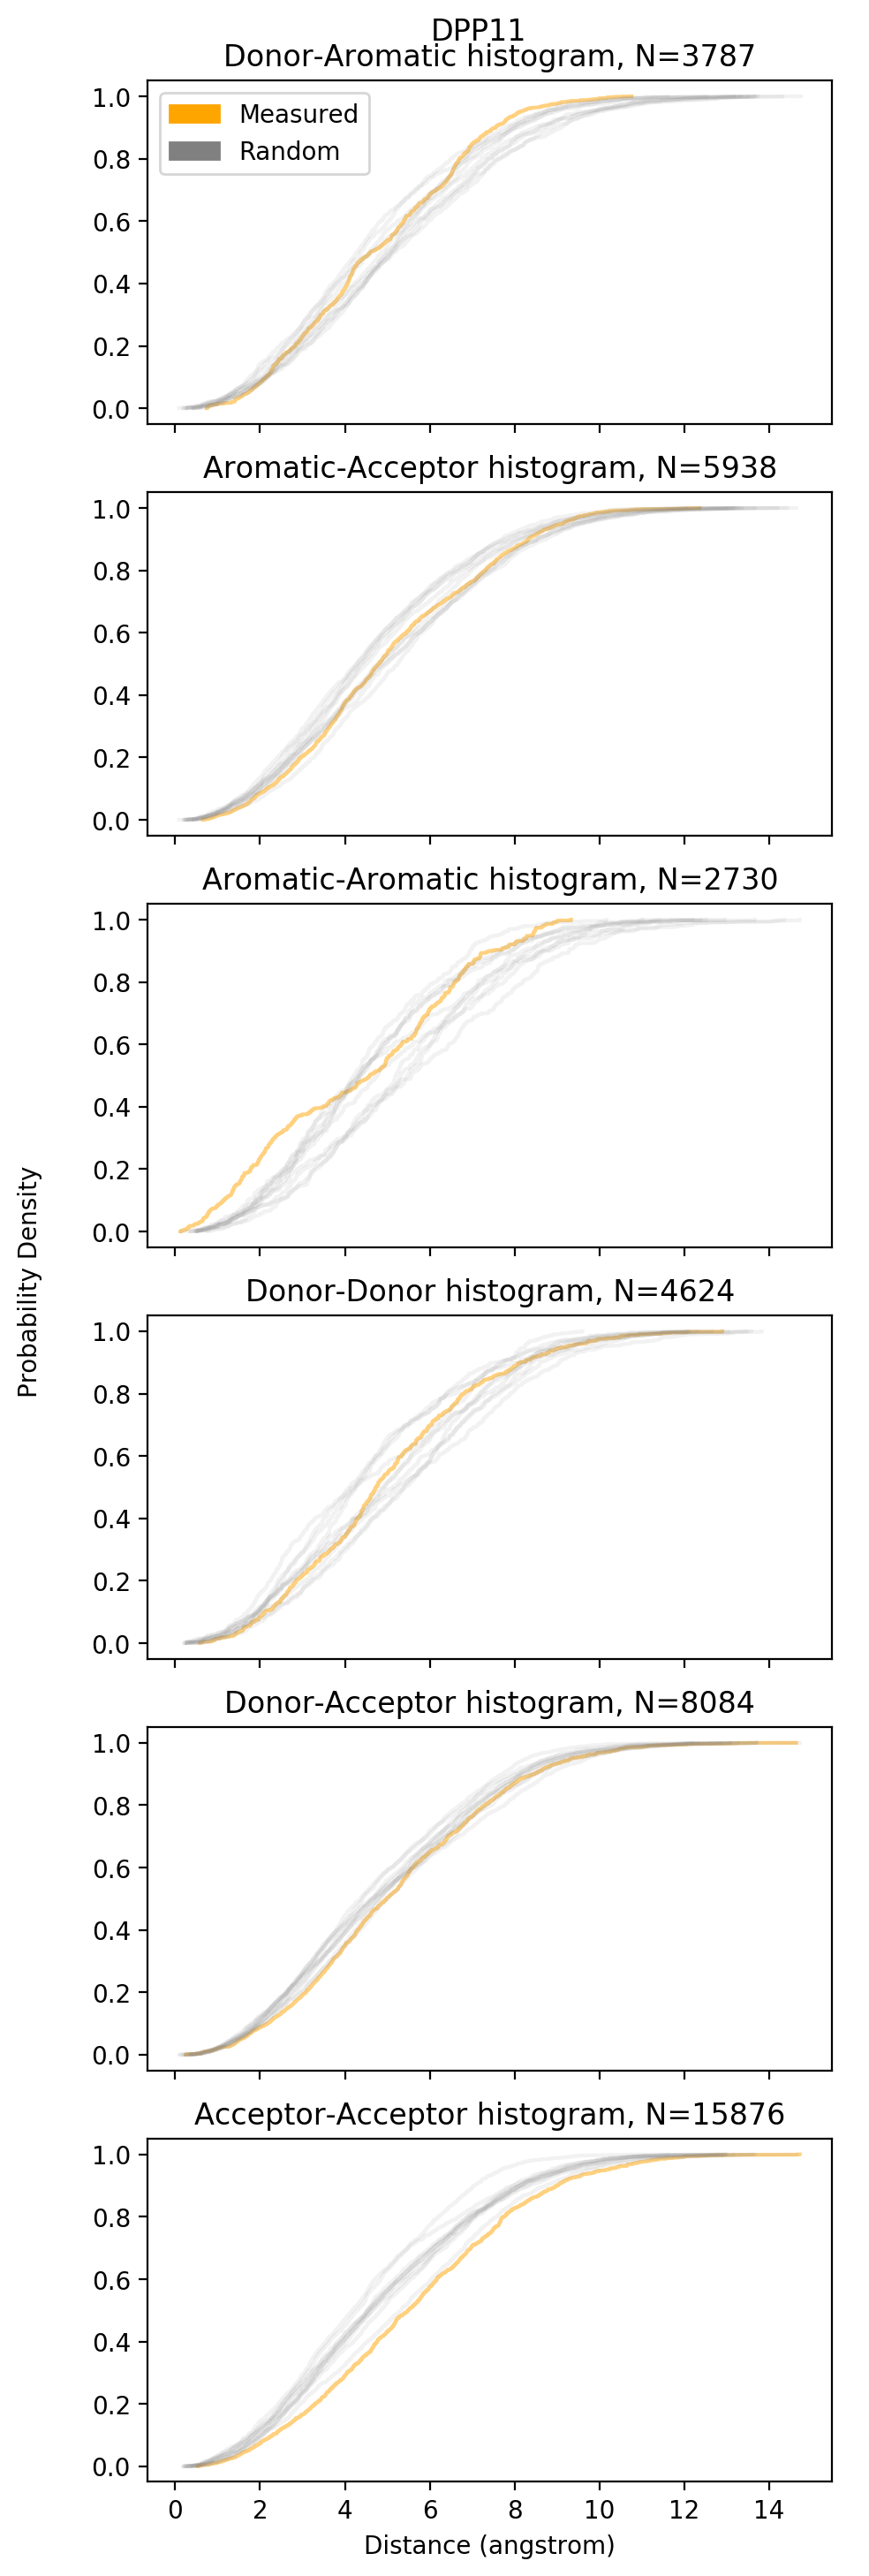

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=(5,18), dpi=200)
fig.suptitle('DPP11', y=0.9)

for i, combo in tqdm(enumerate(pairs), total=6):
    X2 = np.sort(frag_pair_distance_dict[combo])
    W = frag_weight_dict[combo][np.argsort(frag_pair_distance_dict[combo])]
    N = len(frag_pair_distance_dict[combo])

    axs[i].set_title('{} histogram, N={}'.format(combo, len(frag_pair_distance_dict[combo])))
    axs[i].plot(X2, np.cumsum(W)/np.sum(W), alpha=0.5, color='orange')
    
    for n in range(n_rand):
        X2 = np.sort(rand_pair_dicts[n][combo])
        W = rand_weight_dicts[n][combo][np.argsort(rand_pair_dicts[n][combo])]
        N = len(rand_pair_dicts[n][combo])
        axs[i].plot(X2, np.cumsum(W)/np.sum(W), alpha=0.1, color='grey')

legend_elements = [Rectangle((0,0), 1,1 , color='orange', label='Measured'),
               Rectangle((0,0), 1,1,  color='grey', label='Random')]
axs[0].legend(handles=legend_elements, loc='upper left')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Distance (angstrom)')
plt.ylabel('Probability Density', labelpad=20)
fig.show()

# P-Value Inspection

KDE uniformly sampled

In [ ]:
combo_list = []

pvals = []
pval_median = []
pval_iqr = []

nx = 500
n_rand = 10
# n_rand = 50


pairs = ['Donor-Aromatic',
        'Aromatic-Acceptor',
        'Aromatic-Aromatic',
        'Donor-Donor',
        'Donor-Acceptor',
        'Acceptor-Acceptor']

for combo in pairs:
    combo_list.append(combo)
    
    kde_pair = kde_dict_opt[combo]
    print(kde_pair.get_params())
    x = np.linspace(0, np.amax(frag_pair_distance_dict[combo]), nx)
    
    pair_dist = np.exp(kde_pair.score_samples(x.reshape(-1,1)))
    pair_dist = pair_dist.flatten()
    pair_dist = pair_dist # /np.sum(pair_dist)
    
    pval_list = []
    
    rand_dists = []
    for i in range(n_rand):

        kde_rand = rand_kde_dicts[i][combo]
#         print(kde_rand.get_params())
        rand_dist = np.exp(kde_rand.score_samples(x.reshape(-1,1)))

        rand_dist = rand_dist.flatten()
        rand_dist = rand_dist # /np.sum(rand_dist)
    
        rand_dists.append(rand_dist)
        pval_list.append(ks_2samp(pair_dist, rand_dist)[1])
#     pvals.append(pval_list)    
    pval_median.append(np.median(pval_list))
    pval_iqr.append(np.subtract(*np.percentile(pval_list, [75, 25])))


    pvals.append(ks_2samp(pair_dist, np.mean(rand_dists, axis=0))[1])
    
# pval_df = pd.DataFrame(list(zip(combo_list, pvals)), 
#                          columns = ['combo','p-value'])
# print(pval_df.round({'p-value': 4}))

pval_df = pd.DataFrame(list(zip(combo_list, pval_median, pval_iqr)), 
                         columns = ['combo','p-value median', 'p-value iqr'])
print(pval_df.round({'p-value median': 4, 'p-value iqr': 4}))

# print(list(zip(combo_list, pvals)))

KDE tested on original distribution

In [29]:
combo_list = []

pvals = []
pval_median = []
pval_iqr = []

n_rand = 10
# n_rand = 50

pairs = ['Donor-Aromatic',
        'Aromatic-Acceptor',
        'Aromatic-Aromatic',
        'Donor-Donor',
        'Donor-Acceptor',
        'Acceptor-Acceptor']

for combo in tqdm(pairs):
    combo_list.append(combo)
    
    kde_pair = kde_dict_opt[combo]
    x = frag_pair_distance_dict[combo]
    pair_dist = np.exp(kde_pair.score_samples(x.reshape(-1,1)))
    pair_dist = pair_dist.flatten()
    
    pval_list = []
    
    rand_dists = []
    for i in range(n_rand):

        kde_rand = rand_kde_dicts[i][combo]
        rand_dist = np.exp(kde_rand.score_samples(x.reshape(-1,1)))

        rand_dist = rand_dist.flatten()
    
        rand_dists.append(rand_dist)
        pval_list.append(ks_2samp(pair_dist, rand_dist)[1])
    pvals.append(pval_list)    
    pval_median.append(np.median(pval_list))
    pval_iqr.append(np.subtract(*np.percentile(pval_list, [75, 25])))

    # pvals.append(ks_2samp(pair_dist, np.mean(rand_dists, axis=0))[1])
    
# pval_df = pd.DataFrame(list(zip(combo_list, pvals)), 
#                          columns = ['combo','p-value'])
# print(pval_df.round({'p-value': 4}))

pval_df = pd.DataFrame(list(zip(combo_list, pval_median, pval_iqr)), 
                         columns = ['combo','p-value median', 'p-value iqr'])
print(pval_df)
# print(list(zip(combo_list, pvals)))

100%|██████████| 6/6 [07:03<00:00, 70.60s/it] 

               combo  p-value median   p-value iqr
0     Donor-Aromatic    1.062131e-82  7.678485e-50
1  Aromatic-Acceptor    9.495756e-43  1.643854e-31
2  Aromatic-Aromatic   5.327093e-132  1.615534e-83
3        Donor-Donor    8.405796e-40  6.771282e-28
4     Donor-Acceptor   2.183369e-136  4.946657e-68
5  Acceptor-Acceptor   1.332367e-120  1.662118e-75


In [4]:
pval_median = []
pval_iqr = []
pvals = []

combo_list = []
n_rand = 10

def rounddown(x):
    return int(math.floor(x / 10.0)) * 10
    
# test = ['Acceptor-Acceptor']
for i, combo in tqdm(enumerate(pairs), total=6):
    combo_list.append(combo)
    real = frag_pair_distance_dict[combo]
    n1 = len(real)

    pval_list = []
    for n in range(n_rand):
        rand = rand_pair_dicts[n][combo]

        n2 = len(rand)
        N = rounddown(min(n1,n2))

        # account for length mismatch
        pval_list.append(ks_2samp(np.random.choice(real, N, replace=False), np.random.choice(rand, N, replace=False), mode='exact')[1]) 

    pvals.append(pval_list)
    pval_median.append(np.median(pval_list))
    pval_iqr.append(np.subtract(*np.percentile(pval_list, [75, 25])))

pval_df = pd.DataFrame(list(zip(combo_list, pval_median, pval_iqr)), 
                         columns = ['combo','p-value median', 'p-value iqr'])
print('Unweighted Distributions')
print(pval_df)

for i, combo in enumerate(combo_list):
    print(combo)
    print(np.sort(pvals[i]))

100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


Unweighted Distributions
               combo  p-value median   p-value iqr
0     Donor-Aromatic    4.665549e-08  2.311378e-04
1  Aromatic-Acceptor    9.090841e-12  7.759504e-09
2  Aromatic-Aromatic    3.777782e-40  1.192102e-27
3        Donor-Donor    9.857573e-15  9.414236e-12
4     Donor-Acceptor    4.239289e-20  1.029427e-14
5  Acceptor-Acceptor   4.328561e-102  1.156534e-56
Donor-Aromatic
[7.36464911e-28 3.95321192e-17 1.13923273e-15 5.59733962e-12
 1.55666830e-08 7.77443053e-08 1.30599838e-07 3.08140151e-04
 4.79662776e-03 1.38251224e-02]
Aromatic-Acceptor
[1.45800907e-44 5.04829447e-36 2.43256289e-35 6.14613868e-18
 3.56401417e-14 1.81460414e-11 5.48444418e-09 8.51785684e-09
 3.01133832e-03 1.81313255e-02]
Aromatic-Aromatic
[1.16444453e-55 5.97129114e-53 1.58235106e-49 1.56085505e-48
 5.22619526e-41 7.03294473e-40 2.03996777e-37 1.58946940e-27
 7.55532790e-15 9.76421696e-11]
Donor-Donor
[4.54846342e-44 1.95106666e-28 3.93615756e-28 6.45249741e-18
 8.20525956e-15 1.15098870e-14 2

In [10]:
pval_median = []
pval_iqr = []
pvals = []
n_list = []

combo_list = []
n_rand = 10

def rounddown(x):
    return int(math.floor(x / 10.0)) * 10

# test = ['Acceptor-Acceptor']
for i, combo in tqdm(enumerate(pairs), total=6):
    combo_list.append(combo)
    real = frag_pair_distance_dict[combo]
    W = frag_weight_dict[combo][np.argsort(real)]

    weighted_real = np.cumsum(W)/np.sum(W)
    n1 = len(weighted_real)

    pval_list = []
    for n in range(n_rand):
        rand = rand_pair_dicts[n][combo]
        W = rand_weight_dicts[n][combo][np.argsort(rand)]
        weighted_rand = np.cumsum(W)/np.sum(W)

        n2 = len(weighted_rand)
        N = rounddown(min(n1,n2))

        # account for length mismatch
        pval_list.append(ks_2samp(np.random.choice(weighted_real, N, replace=False), np.random.choice(weighted_rand, N, replace=False), mode='exact')[1]) 
        # pval_list.append(ks_2samp(weighted_real, weighted_rand)[1])

    n_list.append(n1)
    pvals.append(pval_list)
    pval_median.append(np.median(pval_list))
    pval_iqr.append(np.subtract(*np.percentile(pval_list, [75, 25])))

pval_df = pd.DataFrame(list(zip(combo_list, pval_median, pval_iqr, n_list)), 
                         columns = ['combo','p-value median', 'p-value iqr', 'n1'])
print('Weighted Distributions')
print(pval_df)

for i, combo in enumerate(combo_list):
    print(combo)
    print(np.sort(pvals[i]))

100%|██████████| 6/6 [00:00<00:00, 22.52it/s]


Weighted Distributions
               combo  p-value median  p-value iqr     n1
0     Donor-Aromatic        0.636105     0.068301   3787
1  Aromatic-Acceptor        0.414275     0.154837   5938
2  Aromatic-Aromatic        0.102658     0.070395   2730
3        Donor-Donor        0.999429     0.001457   4624
4     Donor-Acceptor        0.998798     0.007138   8084
5  Acceptor-Acceptor        0.978036     0.027714  15876
Donor-Aromatic
[0.41810366 0.57191196 0.61198265 0.62798068 0.635068   0.63714214
 0.66876472 0.68945601 0.7983012  0.84867573]
Aromatic-Acceptor
[0.16322879 0.23741313 0.31043878 0.34207372 0.37693029 0.45162004
 0.46406545 0.4762245  0.64709627 0.73794147]
Aromatic-Aromatic
[0.03778967 0.0457788  0.05917129 0.06774349 0.10134237 0.10397293
 0.13133423 0.13183438 0.18712028 0.29977842]
Donor-Donor
[0.98239462 0.99731261 0.99822628 0.99860462 0.99941512 0.99944211
 0.99964549 0.99982143 0.99984862 0.9999086 ]
Donor-Acceptor
[0.92070145 0.99268106 0.99268198 0.99286245 0.9

# Plots

100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


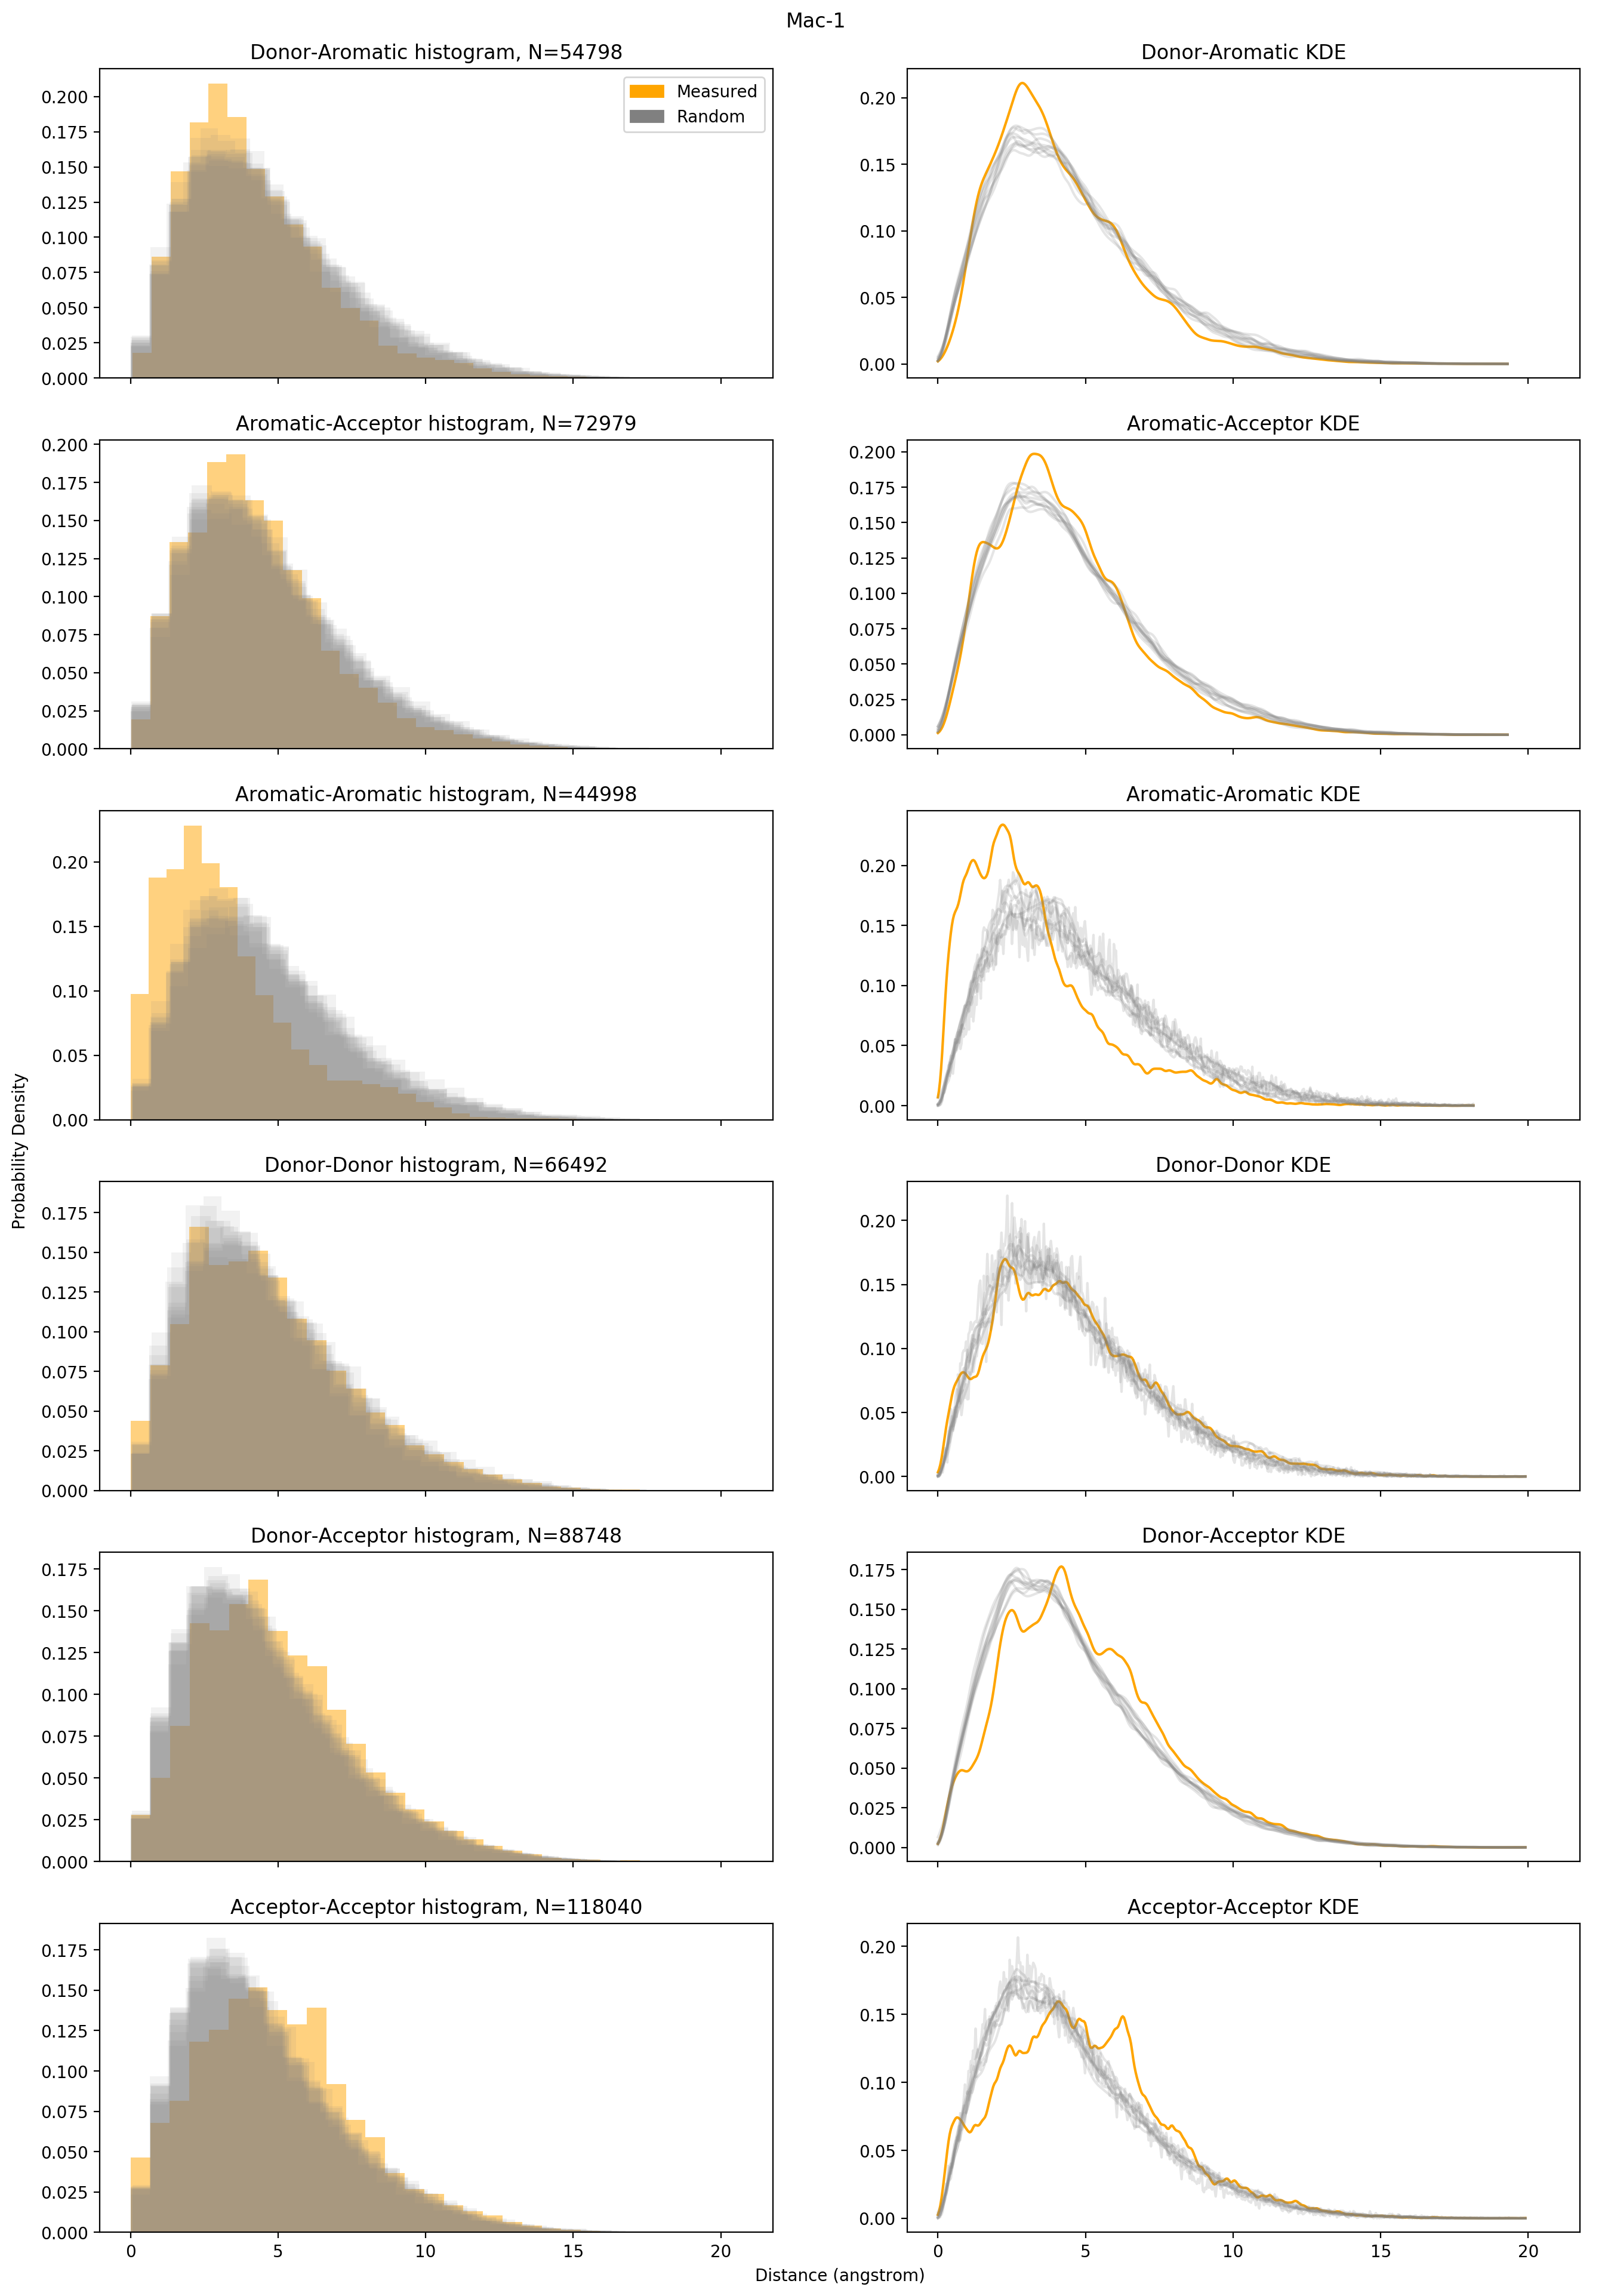

In [10]:
n_bins = 30
n_rand = 10
nx = 500

# mpl.rcParams['figure.dpi'] = 200

fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True, figsize=(16,24), dpi=200)
# fig.suptitle('DPP11', y=0.9)
fig.suptitle('Mac-1', y=0.9)
# fig.suptitle('MPro', y=0.9)

for i, combo in tqdm(enumerate(pairs), total=6):
    axs[i,0].set_title('{} histogram, N={}'.format(combo, len(frag_pair_distance_dict[combo])))
    axs[i,0].hist(frag_pair_distance_dict[combo], bins=n_bins, alpha = 0.5, density=True, color='orange')
    
    # axs[i,1].set_title('{} KDE, K-S pval median ={:.2e}'.format(combo, pval_median[i]))
    axs[i,1].set_title('{} KDE'.format(combo))
        
    kde_pair = kde_dict_opt[combo]
    
    x = np.linspace(0, np.amax(frag_pair_distance_dict[combo]), nx)
    
    pair_dist = np.exp(kde_pair.score_samples(x.reshape(-1,1)))
    pair_dist = pair_dist.flatten()
    pair_dist = pair_dist#/np.sum(pair_dist)
    
    axs[i,1].plot(x, pair_dist, color='orange')
    
    for n in range(n_rand):
        axs[i,0].hist(rand_pair_dicts[n][combo], bins=30, alpha=0.1, density=True, color='grey')
        
        kde_rand = rand_kde_dicts[n][combo]
    
        rand_dist = np.exp(kde_rand.score_samples(x.reshape(-1,1)))
        rand_dist = rand_dist.flatten()
        rand_dist = rand_dist#/np.sum(rand_dist)
        
        axs[i,1].plot(x, rand_dist, alpha=0.2, color='grey')
        
legend_elements = [Rectangle((0,0), 1,1 , color='orange', label='Measured'),
               Rectangle((0,0), 1,1,  color='grey', label='Random')]
axs[0,0].legend(handles=legend_elements, loc='upper right')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Distance (angstrom)')
plt.ylabel('Probability Density', labelpad=20)
fig.show()

100%|██████████| 6/6 [00:15<00:00,  2.52s/it]


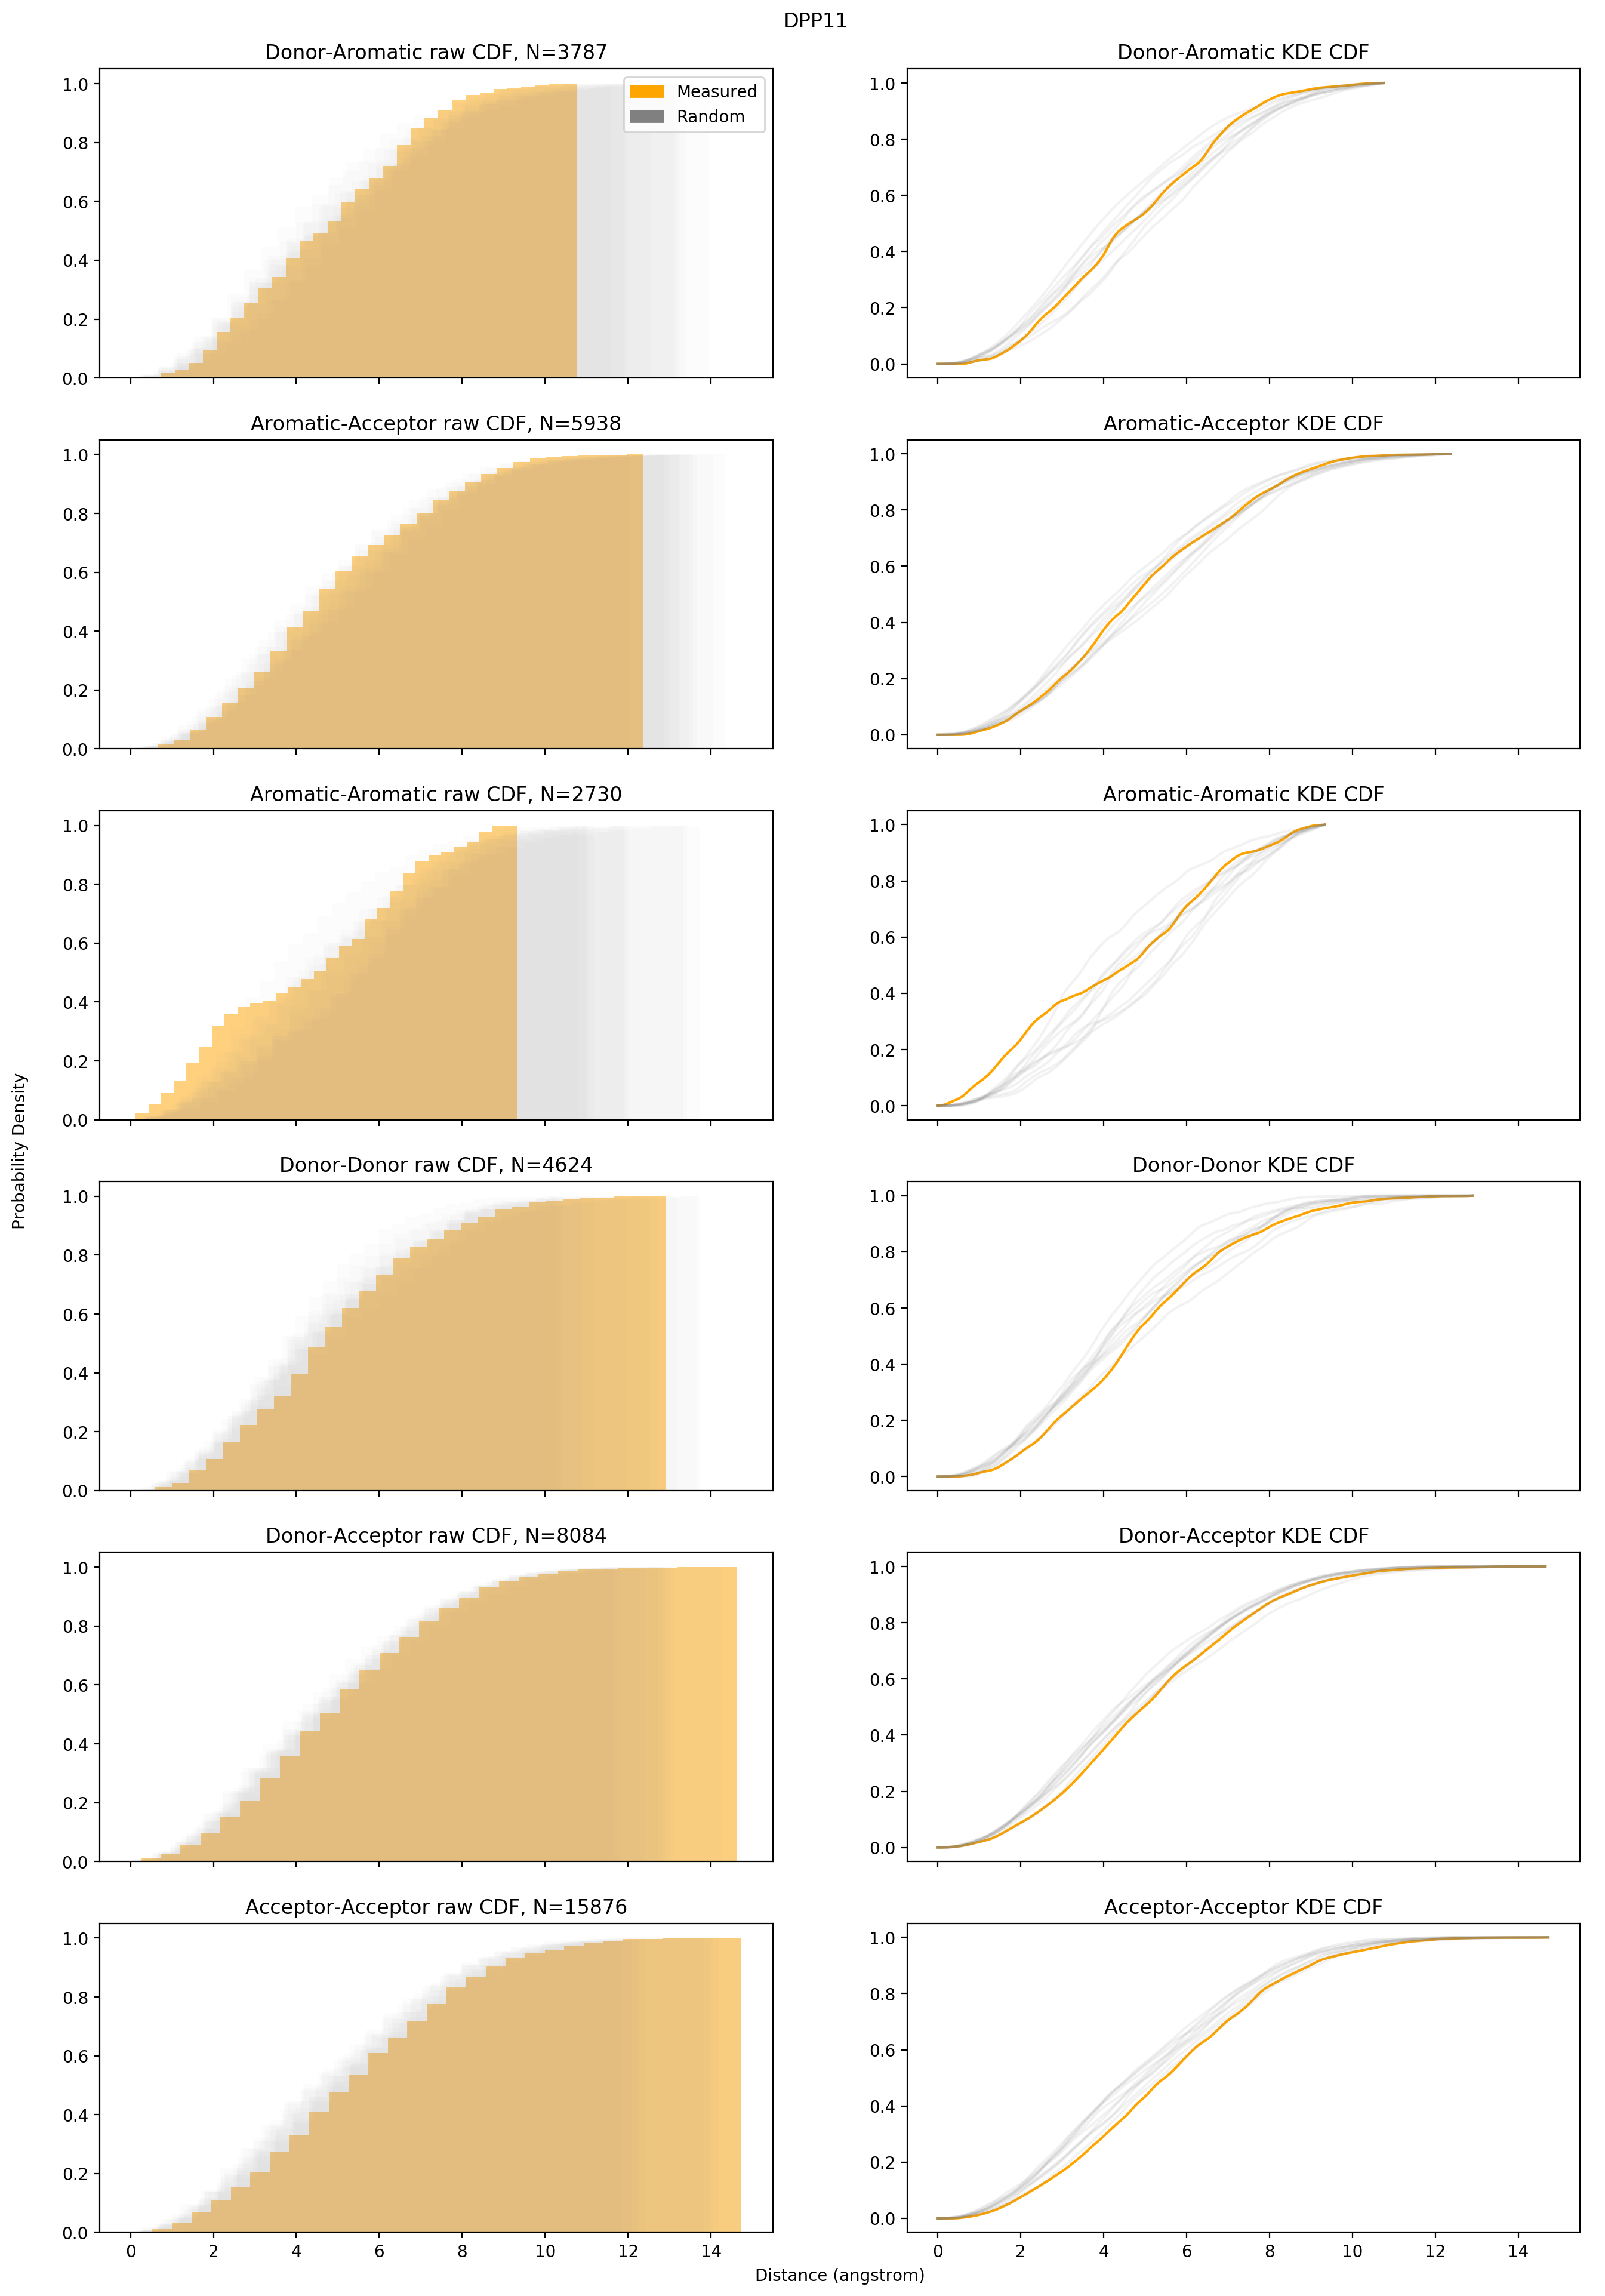

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

n_bins = 30
n_rand = 10
nx = 500

# mpl.rcParams['figure.dpi'] = 200

fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True, figsize=(16,24), dpi=200)
fig.suptitle('DPP11', y=0.9)

for i, combo in tqdm(enumerate(pairs), total=6):
    axs[i,0].set_title('{} raw CDF, N={}'.format(combo, len(frag_pair_distance_dict[combo])))
    axs[i,0].hist(frag_pair_distance_dict[combo], bins=n_bins, alpha = 0.5, density=True, color='orange', cumulative=True)
    
    axs[i,1].set_title('{} KDE CDF'.format(combo))
        
    kde_pair = kde_dict_opt[combo]
    
    x = np.linspace(0, np.amax(frag_pair_distance_dict[combo]), nx)
    
    pair_dist = np.exp(kde_pair.score_samples(x.reshape(-1,1)))
    pair_dist = pair_dist.flatten()
    pair_dist = pair_dist#/np.sum(pair_dist)
    
    axs[i,1].plot(x, np.cumsum(pair_dist/np.sum(pair_dist)), color='orange')
    
    for n in range(n_rand):
        axs[i,0].hist(rand_pair_dicts[n][combo], bins=30, alpha=0.02, density=True, color='grey', cumulative=True)
        
        kde_rand = rand_kde_dicts[n][combo]
    
        rand_dist = np.exp(kde_rand.score_samples(x.reshape(-1,1)))
        rand_dist = rand_dist.flatten()
        rand_dist = rand_dist#/np.sum(rand_dist)
        
        axs[i,1].plot(x, np.cumsum(rand_dist/np.sum(rand_dist)), alpha=0.1, color='grey')
        
legend_elements = [Rectangle((0,0), 1,1 , color='orange', label='Measured'),
               Rectangle((0,0), 1,1,  color='grey', label='Random')]
axs[0,0].legend(handles=legend_elements, loc='upper right')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Distance (angstrom)')
plt.ylabel('Probability Density', labelpad=20)
fig.show()